In [1]:
import os
import json
import copy
import numpy as np
import pandas as pd

from time import time
from tqdm import tqdm, trange

import torch
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

from Model import MLP_with_pretrain, Whole_model_LGCN
from LightGCN import LightGCN
from utils import column_idx, make_edges_symmetry

/home/wcks13589/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [23]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

shop_col = 'stonc_6_label'
#shop_col = 'mcc'
#shop_col = 'stonc_label'
#shop_col = 'stonc_10_label'

epochs = 400
early_stop = 20
batch_size = 2048
learning_rate = 0.001
embedding_size = 64

n_layers = 3

edges_path = './edges_weight_stonc6.pkl'
pretrain_weights = './weights/LightGCNencoder_weights_stonc6'

result_path = './result/LGCN_stonc6.csv'

In [3]:
sample_data_path = './data/sample'

chid_dict_file_name = 'sample_50k_idx_map.npy'
cdtx_file_name = 'sample_50k_cdtx.csv'
cust_file_name = 'sample_50k_cust.csv'

sample_chid_dict = os.path.join(sample_data_path, chid_dict_file_name)
sample_cdtx_file = os.path.join(sample_data_path, cdtx_file_name)
sample_cust_file = os.path.join(sample_data_path, cust_file_name)

In [4]:
downstream_data_path = './data/downstream'

x_train_file_name = 'x_train.csv'
x_test_file_name = 'x_test.csv'
y_train_file_name = 'y_train.csv'
y_test_file_name = 'y_test.csv'

x_train_file = os.path.join(downstream_data_path, x_train_file_name)
x_test_file = os.path.join(downstream_data_path, x_test_file_name)
y_train_file = os.path.join(downstream_data_path, y_train_file_name)
y_test_file = os.path.join(downstream_data_path, y_test_file_name)

In [41]:
df_cdtx = pd.read_csv(sample_cdtx_file)
df_cdtx.sort_values('csmdt')

df_cust = pd.read_csv(sample_cust_file)
df_cust.drop_duplicates(ignore_index=True, inplace=True)

idx_map = np.load(sample_chid_dict, allow_pickle=True).tolist()

In [42]:
l = len(idx_map)
for i , j in enumerate(sorted(df_cdtx[shop_col].unique())):
    idx_map[j] = i+l

In [33]:
df_cdtx.chid = df_cdtx.chid.map(idx_map)
df_cdtx[shop_col] = df_cdtx[shop_col].map(idx_map)

df_cust.chid = df_cust.chid.map(idx_map)

In [34]:
df_cdtx.csmdt = df_cdtx.csmdt.apply(lambda x: x[:8]+'01')
df_cdtx.objam = df_cdtx.objam.apply(lambda x: int(x))

df_cust.data_dt = df_cust.data_dt.apply(lambda x: x[:10])

In [9]:
ignore_cols = ['chid', 'data_dt']
category_cols = ['masts', 'educd', 'naty', 'trdtp', 'poscd', 'cuorg']
numeric_cols = sorted(set(df_cust.columns) - set(category_cols) - set(ignore_cols)) + ['objam']

In [38]:
mapper = {col: {value: index for index, value in enumerate(sorted(df_cust[col].unique()))} 
          for col in category_cols}

df_cust[category_cols] = df_cust[category_cols].apply(lambda x: x.map(mapper[x.name]))

In [40]:
df_cdtx = df_cdtx[df_cdtx.csmdt < '2019-01-01']
df_cust = df_cust[df_cust.data_dt == '2018-12-01'].sort_values(by=['chid'])

df_cust['objam'] = np.ma.log(df_cdtx.groupby(['chid']).sum().objam.values/12).filled(0)

In [12]:
x_scaler = MinMaxScaler()
df_cust[numeric_cols] = x_scaler.fit_transform(df_cust[numeric_cols])

In [13]:
df_cust_ = df_cust[category_cols+numeric_cols]

cust_feature = torch.Tensor(df_cust_.to_numpy())
shop_feature = torch.zeros(len(idx_map)-cust_feature.shape[0], cust_feature.shape[1])
x_feature = torch.cat([cust_feature, shop_feature])

In [14]:
edge_pairs = df_cdtx[['chid', shop_col]].copy()
edge_pairs.drop_duplicates(ignore_index=True, inplace=True)
edge_pairs = edge_pairs.to_numpy().T

edge_pairs = make_edges_symmetry(edge_pairs)
edge_pairs = torch.LongTensor(edge_pairs)

In [15]:
x_train = pd.read_csv(x_train_file)
x_test = pd.read_csv(x_test_file)

y_train = pd.read_csv(y_train_file)
y_test = pd.read_csv(y_test_file)

In [16]:
ignore_cols = ['chid']
category_cols = ['masts', 'educd', 'naty', 'trdtp', 'poscd', 'cuorg']
numeric_cols = sorted(set(x_train.columns) - set(category_cols) - set(ignore_cols))

In [48]:
category_dims = {col_name : len(uni)
                 for col_name, uni in mapper.items()}
category_dict = column_idx(df_cust_, category_cols)
numeric_dict = column_idx(df_cust_, numeric_cols)

input_dim = len(category_dict)*embedding_size + len(numeric_dict) + embedding_size

layer_dims = [input_dim, 1]

In [18]:
train_dataset = TensorDataset(torch.from_numpy(x_train.to_numpy()),
                              torch.from_numpy(y_train.to_numpy()))
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = TensorDataset(torch.from_numpy(x_test.to_numpy()),
                              torch.from_numpy(y_test.to_numpy()))
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)

In [19]:
with open(edges_path, 'rb') as f:
    import pickle
    data = pickle.load(f)

n_users = cust_feature.shape[0]
n_shops = shop_feature.shape[0]

In [49]:
pre_train_model = LightGCN(embedding_size, n_users, n_shops, n_layers, data.train_pos_edge_index[:,:int(data.train_pos_edge_index.shape[1]/2)])
pre_train_model.load_state_dict(torch.load(pretrain_weights))
pre_train_model.train()

down_stream_model = MLP_with_pretrain(category_dims, layer_dims, embedding_size)

In [50]:
model = Whole_model_LGCN(pre_train_model, down_stream_model).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

Whole_model_LGCN(
  (pre_train_model): LightGCN(
    (embedding_user): Embedding(50000, 64)
    (embedding_item): Embedding(78560, 64)
  )
  (down_stream_model): MLP_with_pretrain(
    (model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=472, out_features=1, bias=True)
        (1): ReLU()
      )
    )
    (embedding_dict): ModuleDict(
      (masts): Embedding(3, 64)
      (educd): Embedding(6, 64)
      (naty): Embedding(2, 64)
      (trdtp): Embedding(27, 64)
      (poscd): Embedding(9, 64)
      (cuorg): Embedding(30, 64)
    )
  )
)


In [51]:
best_loss = 1e10
early_cnt = 0
RMSE = []
for epoch in range(epochs):
    
    train_loss = 0
    test_loss = 0
    train_output = np.array([])
    train_y = np.array([])
    test_output = np.array([])
    test_y = np.array([])
    
    for x , y in tqdm(train_loader):
        x, y = x.float().to(device), y.float().to(device)
        model.train()
        optimizer.zero_grad()
        
        output = model(x, category_dict, numeric_dict)

        loss = criterion(output, y)
        train_loss += loss.item()
        train_output = np.concatenate([train_output,output.cpu().detach().numpy().reshape(-1)])
        train_y = np.concatenate([train_y,y.cpu().detach().numpy().reshape(-1)])
        
        loss.backward()
        optimizer.step()
        
    for x , y in test_loader:
        x, y = x.float().to(device), y.float().to(device)
        model.eval()        
        output = model(x, category_dict, numeric_dict)
        loss = criterion(output, y)
        test_loss += loss.item()
        test_output = np.concatenate([test_output,output.cpu().detach().numpy().reshape(-1)])
        test_y = np.concatenate([test_y,y.cpu().detach().numpy().reshape(-1)])
    
    #train_loss = np.sqrt(train_loss/len(train_loader))
    #test_loss = np.sqrt(test_loss/len(test_loader))
    
    train_output, train_y = np.e**train_output, np.e**train_y
    train_RMSE = mean_squared_error(train_output, train_y, squared=False)
    train_mean = mean_absolute_error(train_output, train_y)
    train_median = median_absolute_error(train_output, train_y)
    
    test_output, test_y = np.e**test_output, np.e**test_y
    test_RMSE = mean_squared_error(test_output, test_y, squared=False)
    test_mean = mean_absolute_error(test_output, test_y)
    test_median = median_absolute_error(test_output, test_y)
    
    print(f'epoch:{epoch}\ntrain loss:{train_RMSE:.0f},test loss:{test_RMSE:.0f}\ntrain MAE(mean):{train_mean:.0f},test MAE(mean):{test_mean:.0f}\ntrain MAE(median):{train_median:.0f}, test MAE(median):{test_median:.0f}')
    
    if test_RMSE <= best_loss:
        best_model_params = copy.deepcopy(model.state_dict())
        best_loss = test_RMSE
        print('\tBetter!')
        early_cnt = 0
    else:
        early_cnt += 1
    
    if early_cnt >= early_stop:
        break

model.load_state_dict(best_model_params)

  0%|          | 1/245 [00:00<00:28,  8.55it/s]

epoch:0
train loss:1018046,test loss:616374
train MAE(mean):76662,test MAE(mean):84032
train MAE(median):11776, test MAE(median):12292
	Better!


  0%|          | 1/245 [00:00<00:27,  8.94it/s]

epoch:1
train loss:1017926,test loss:615992
train MAE(mean):75970,test MAE(mean):82813
train MAE(median):11142, test MAE(median):11465
	Better!


  0%|          | 1/245 [00:00<00:27,  8.79it/s]

epoch:2
train loss:1017336,test loss:614220
train MAE(mean):73579,test MAE(mean):79657
train MAE(median):9917, test MAE(median):10566
	Better!


  0%|          | 1/245 [00:00<00:27,  9.03it/s]

epoch:3
train loss:1015897,test loss:610540
train MAE(mean):70375,test MAE(mean):76456
train MAE(median):9217, test MAE(median):10247
	Better!


  0%|          | 1/245 [00:00<00:28,  8.50it/s]

epoch:4
train loss:1013128,test loss:604015
train MAE(mean):67017,test MAE(mean):73416
train MAE(median):8732, test MAE(median):9964
	Better!


  0%|          | 0/245 [00:00<?, ?it/s]

epoch:5
train loss:1009005,test loss:595991
train MAE(mean):64054,test MAE(mean):71189
train MAE(median):8351, test MAE(median):9575
	Better!


  0%|          | 1/245 [00:00<00:27,  8.80it/s]

epoch:6
train loss:1004405,test loss:584936
train MAE(mean):62005,test MAE(mean):69675
train MAE(median):8067, test MAE(median):9298
	Better!


  0%|          | 1/245 [00:00<00:34,  7.00it/s]

epoch:7
train loss:999044,test loss:573576
train MAE(mean):60630,test MAE(mean):68704
train MAE(median):7892, test MAE(median):9594
	Better!


  0%|          | 1/245 [00:00<00:27,  8.73it/s]

epoch:8
train loss:995180,test loss:565552
train MAE(mean):59762,test MAE(mean):67843
train MAE(median):7823, test MAE(median):9147
	Better!


  0%|          | 1/245 [00:00<00:28,  8.63it/s]

epoch:9
train loss:991420,test loss:557334
train MAE(mean):59110,test MAE(mean):67306
train MAE(median):7756, test MAE(median):9061
	Better!


  0%|          | 1/245 [00:00<00:34,  7.03it/s]

epoch:10
train loss:989428,test loss:547648
train MAE(mean):58705,test MAE(mean):67089
train MAE(median):7726, test MAE(median):9262
	Better!


  0%|          | 1/245 [00:00<00:30,  8.09it/s]

epoch:11
train loss:986748,test loss:543924
train MAE(mean):58423,test MAE(mean):66731
train MAE(median):7698, test MAE(median):8971
	Better!


  0%|          | 1/245 [00:00<00:28,  8.55it/s]

epoch:12
train loss:985955,test loss:547331
train MAE(mean):58246,test MAE(mean):66748
train MAE(median):7707, test MAE(median):8819


  0%|          | 1/245 [00:00<00:28,  8.48it/s]

epoch:13
train loss:985508,test loss:534863
train MAE(mean):58042,test MAE(mean):66470
train MAE(median):7665, test MAE(median):9129
	Better!


  0%|          | 1/245 [00:00<00:35,  6.83it/s]

epoch:14
train loss:984864,test loss:530746
train MAE(mean):57975,test MAE(mean):66388
train MAE(median):7693, test MAE(median):8688
	Better!


  0%|          | 1/245 [00:00<00:27,  8.91it/s]

epoch:15
train loss:984782,test loss:518848
train MAE(mean):57862,test MAE(mean):66802
train MAE(median):7664, test MAE(median):9782
	Better!


  0%|          | 1/245 [00:00<00:28,  8.64it/s]

epoch:16
train loss:984037,test loss:528900
train MAE(mean):57841,test MAE(mean):66340
train MAE(median):7683, test MAE(median):9043


  0%|          | 1/245 [00:00<00:29,  8.37it/s]

epoch:17
train loss:983272,test loss:534932
train MAE(mean):57723,test MAE(mean):66401
train MAE(median):7687, test MAE(median):8645


  0%|          | 1/245 [00:00<00:28,  8.67it/s]

epoch:18
train loss:983529,test loss:532190
train MAE(mean):57699,test MAE(mean):66354
train MAE(median):7680, test MAE(median):8989


  0%|          | 1/245 [00:00<00:26,  9.25it/s]

epoch:19
train loss:984096,test loss:529093
train MAE(mean):57692,test MAE(mean):66217
train MAE(median):7675, test MAE(median):8928


  0%|          | 1/245 [00:00<00:28,  8.53it/s]

epoch:20
train loss:983283,test loss:513606
train MAE(mean):57637,test MAE(mean):66136
train MAE(median):7668, test MAE(median):9396
	Better!


  0%|          | 1/245 [00:00<00:24,  9.97it/s]

epoch:21
train loss:982926,test loss:532030
train MAE(mean):57602,test MAE(mean):66290
train MAE(median):7670, test MAE(median):8681


  0%|          | 1/245 [00:00<00:33,  7.22it/s]

epoch:22
train loss:981850,test loss:524472
train MAE(mean):57519,test MAE(mean):66241
train MAE(median):7646, test MAE(median):9308


  0%|          | 1/245 [00:00<00:27,  8.98it/s]

epoch:23
train loss:981982,test loss:519344
train MAE(mean):57519,test MAE(mean):66080
train MAE(median):7669, test MAE(median):9172


  0%|          | 1/245 [00:00<00:27,  8.89it/s]

epoch:24
train loss:983804,test loss:521128
train MAE(mean):57620,test MAE(mean):66146
train MAE(median):7649, test MAE(median):8766


  0%|          | 1/245 [00:00<00:29,  8.31it/s]

epoch:25
train loss:982697,test loss:524754
train MAE(mean):57653,test MAE(mean):66297
train MAE(median):7689, test MAE(median):9085


  0%|          | 1/245 [00:00<00:27,  9.00it/s]

epoch:26
train loss:983129,test loss:519016
train MAE(mean):57582,test MAE(mean):66056
train MAE(median):7663, test MAE(median):8942


  0%|          | 1/245 [00:00<00:28,  8.55it/s]

epoch:27
train loss:982755,test loss:519687
train MAE(mean):57548,test MAE(mean):66140
train MAE(median):7639, test MAE(median):8741


  0%|          | 1/245 [00:00<00:34,  7.13it/s]

epoch:28
train loss:982145,test loss:522252
train MAE(mean):57525,test MAE(mean):66063
train MAE(median):7642, test MAE(median):8896


  0%|          | 1/245 [00:00<00:26,  9.20it/s]

epoch:29
train loss:983392,test loss:525093
train MAE(mean):57558,test MAE(mean):66176
train MAE(median):7662, test MAE(median):8743


  0%|          | 1/245 [00:00<00:27,  8.79it/s]

epoch:30
train loss:983515,test loss:517340
train MAE(mean):57626,test MAE(mean):66234
train MAE(median):7674, test MAE(median):8566


  0%|          | 1/245 [00:00<00:27,  8.98it/s]

epoch:31
train loss:982509,test loss:515926
train MAE(mean):57661,test MAE(mean):66431
train MAE(median):7648, test MAE(median):9796


  0%|          | 1/245 [00:00<00:27,  8.88it/s]

epoch:32
train loss:983389,test loss:531660
train MAE(mean):57594,test MAE(mean):66581
train MAE(median):7685, test MAE(median):8631


  0%|          | 1/245 [00:00<00:26,  9.29it/s]

epoch:33
train loss:982207,test loss:520075
train MAE(mean):57521,test MAE(mean):66085
train MAE(median):7649, test MAE(median):9223


  0%|          | 1/245 [00:00<00:27,  8.95it/s]

epoch:34
train loss:982620,test loss:530652
train MAE(mean):57573,test MAE(mean):66381
train MAE(median):7673, test MAE(median):8623


  0%|          | 1/245 [00:00<00:27,  8.87it/s]

epoch:35
train loss:983847,test loss:516671
train MAE(mean):57625,test MAE(mean):66080
train MAE(median):7677, test MAE(median):9054


  0%|          | 1/245 [00:00<00:29,  8.28it/s]

epoch:36
train loss:982379,test loss:516256
train MAE(mean):57528,test MAE(mean):66282
train MAE(median):7653, test MAE(median):9266


  0%|          | 1/245 [00:00<00:29,  8.35it/s]

epoch:37
train loss:983492,test loss:523098
train MAE(mean):57557,test MAE(mean):66294
train MAE(median):7646, test MAE(median):9331


  0%|          | 1/245 [00:00<00:35,  6.78it/s]

epoch:38
train loss:984052,test loss:519611
train MAE(mean):57611,test MAE(mean):66055
train MAE(median):7656, test MAE(median):8973


  0%|          | 1/245 [00:00<00:32,  7.51it/s]

epoch:39
train loss:983095,test loss:521646
train MAE(mean):57505,test MAE(mean):66180
train MAE(median):7646, test MAE(median):8961


100%|██████████| 245/245 [00:21<00:00, 11.54it/s]


epoch:40
train loss:983985,test loss:517632
train MAE(mean):57577,test MAE(mean):66105
train MAE(median):7649, test MAE(median):9143


<All keys matched successfully>

In [26]:
train_output = np.array([])
train_y = np.array([])
test_output = np.array([])
test_y = np.array([])

model.eval()

for x , y in tqdm(train_loader):
    x, y = x.float().to(device), y.float().to(device)

    output = model(x, category_dict, numeric_dict)
    train_output = np.concatenate([train_output,output.cpu().detach().numpy().reshape(-1)])
    train_y = np.concatenate([train_y,y.cpu().detach().numpy().reshape(-1)])

for x , y in test_loader:
    x, y = x.float().to(device), y.float().to(device)
    output = model(x, category_dict, numeric_dict)
    test_output = np.concatenate([test_output,output.cpu().detach().numpy().reshape(-1)])
    test_y = np.concatenate([test_y,y.cpu().detach().numpy().reshape(-1)])

train_output, train_y = np.e**train_output, np.e**train_y
test_output, test_y = np.e**test_output, np.e**test_y

100%|██████████| 245/245 [00:12<00:00, 20.38it/s]


In [ ]:
print('train\tRMSE: {:.2f} MSE(mean): {:.2f} MSE(median): {:.2f}'.format(
    mean_squared_error(train_y, train_output, squared=False), 
    mean_absolute_error(train_y, train_output), 
    median_absolute_error(train_y, train_output)
))
print('test\tRMSE: {:.2f} MSE(mean): {:.2f} MSE(median): {:.2f}'.format(
    mean_squared_error(test_y, test_output, squared=False), 
    mean_absolute_error(test_y, test_output), 
    median_absolute_error(test_y, test_output)
))

In [ ]:
df_out = x_test[['chid']].copy()
df_out['true'] = test_y
df_out['pred'] = test_output

In [ ]:
df_out

In [ ]:
df_out.to_csv(result_path, index=False, encoding='utf-8')

In [27]:
data

Data(test_neg_edge_index=[2, 72507], test_pos_edge_index=[2, 72507], test_pos_edge_weight=[72507], train_neg_adj_mask=[128560, 128560], train_pos_edge_index=[2, 1232632], train_pos_edge_weight=[1232632], val_neg_edge_index=[2, 36253], val_pos_edge_index=[2, 36253], val_pos_edge_weight=[36253], x=[128560, 30])

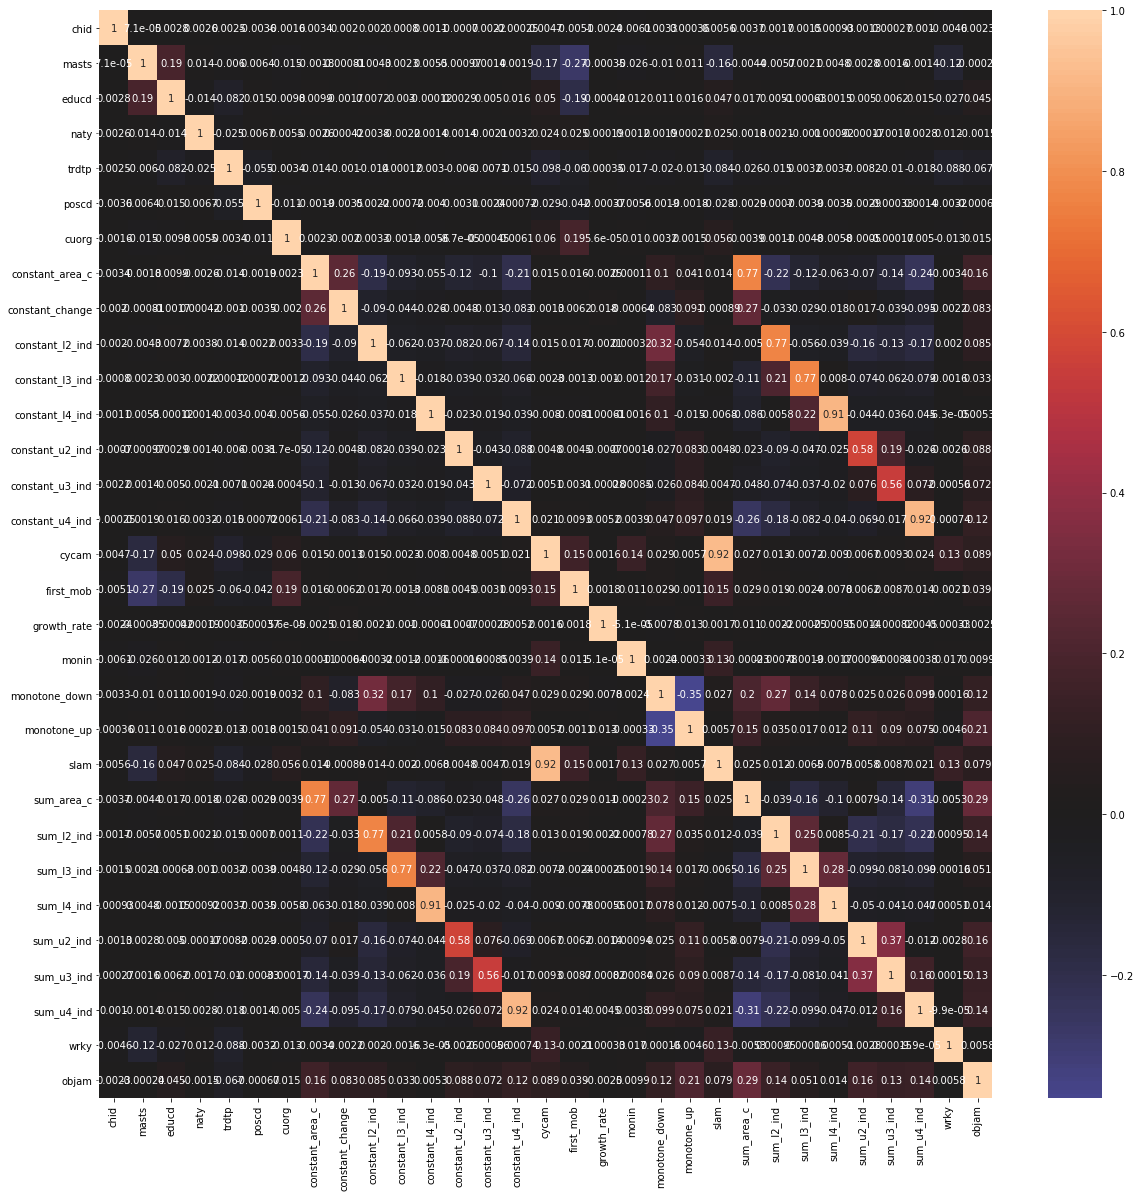

In [47]:
import matplotlib.pyplot as mp, seaborn
mp.figure(figsize=[20,20])
seaborn.heatmap(x_train.corr(), center=0, annot=True)

In [46]:
x_train

,chid,masts,educd,naty,trdtp,poscd,cuorg,constant_area_c,constant_change,constant_l2_ind,...,slam,sum_area_c,sum_l2_ind,sum_l3_ind,sum_l4_ind,sum_u2_ind,sum_u3_ind,sum_u4_ind,wrky,objam
0,0,0,1,1,2,3,6,0.000000,0.0,0.333333,...,0.001071,0.666667,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.020464,0.582280
1,0,0,1,1,2,3,6,0.000000,0.0,0.333333,...,0.001071,0.000000,0.833333,0.166667,0.0,0.000000,0.0,0.0,0.020464,0.000000
2,0,0,1,1,2,3,6,1.000000,0.0,0.000000,...,0.001071,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.020464,0.000000
3,0,0,1,1,2,3,6,0.833333,0.0,0.000000,...,0.001071,0.833333,0.000000,0.000000,0.0,0.166667,0.0,0.0,0.020464,0.000000
4,0,0,1,1,2,3,6,0.000000,0.0,0.000000,...,0.001071,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.020464,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,4,1,24,0,6,0.000000,0.0,0.000000,...,0.009286,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.600670
499996,49999,0,4,1,4,0,6,0.000000,0.0,0.000000,...,0.009286,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.531056
499997,49999,0,4,1,4,0,6,0.000000,0.0,0.000000,...,0.013858,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.534260
499998,49999,0,4,1,4,0,6,0.000000,0.0,0.000000,...,0.013858,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.441946
